In [49]:
%%capture

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams.update({'font.size': 14})
plt.tight_layout()

In [50]:
import os

# Data Exploration

_TODO: cut scorecard data to include only Ivy League's and elite universities._

Let's take a look at Columbia's net price since 2009 (when colleges began reporting student aid data).

In [51]:
scorecards = []

for year in range(9, 17):
    fname = f'MERGED20{year:02}_{(year + 1):02}_PP.csv'
    scorecards.append(pd.read_csv(SCDIR + fname, low_memory=False))
    print('Finished reading', fname)

Finished reading MERGED2009_10_PP.csv
Finished reading MERGED2010_11_PP.csv
Finished reading MERGED2011_12_PP.csv
Finished reading MERGED2012_13_PP.csv
Finished reading MERGED2013_14_PP.csv
Finished reading MERGED2014_15_PP.csv
Finished reading MERGED2015_16_PP.csv
Finished reading MERGED2016_17_PP.csv


In [52]:
# Isolates data for Columbia University from 2009 to 2016.
# At this point, all dollars are nominal.
nominalRows = [s.set_index('INSTNM').loc['Columbia University in the City of New York'] for s in scorecards]

To adjust prices for inflation, we will use consumer price index data to make price data equivalent to 2016 dollars.

In [54]:
cpiData = pd.read_csv('../data/ConsumerPriceIndexData.csv').set_index('Year')

In [55]:
def inflationAdjuster(month):
    finalCpi = cpiData.loc[2016][month]
    def adjust(dollars, year):
        initCpi = cpiData.loc[year][month]
        return dollars * finalCpi / initCpi
    return adjust

In [61]:
colNames = {
    'NPT41_PRIV': 'ANP for 0-30,000 fam income',
    'NPT42_PRIV': 'ANP for 30,001-48,000 fam income',
    'NPT43_PRIV': 'ANP for 48,001-75,000 fam income',
    'NPT44_PRIV': 'ANP for 75,001-110,000 fam income',
    'NPT45_PRIV': 'ANP for 110,000+ fam income',
}

YEARS = [i for i in range(2009, 2017)]

def getAdjustedValues(col):
    # Net prices are calculated around Nov-Jan.
    # IPEDS help desk when asked if I could use December CPI's to adjust
    # net prices for inflation: "Probably." —Mike (the one person who
    # runs the help desk).
    adjust = inflationAdjuster('Dec')
    return [
        adjust(nominalRows[year - 2009][col], year) for year in YEARS
    ]

def comparePriceLines(*cols, title=None):
    plt.figure(figsize=(10,10))
    for col in cols:
        plt.plot(YEARS, getAdjustedValues(col), label=colNames.get(col, col))        
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Average net price in December 2016 dollars')
    plt.ylim(bottom=0)
    if title:
        plt.title(title)

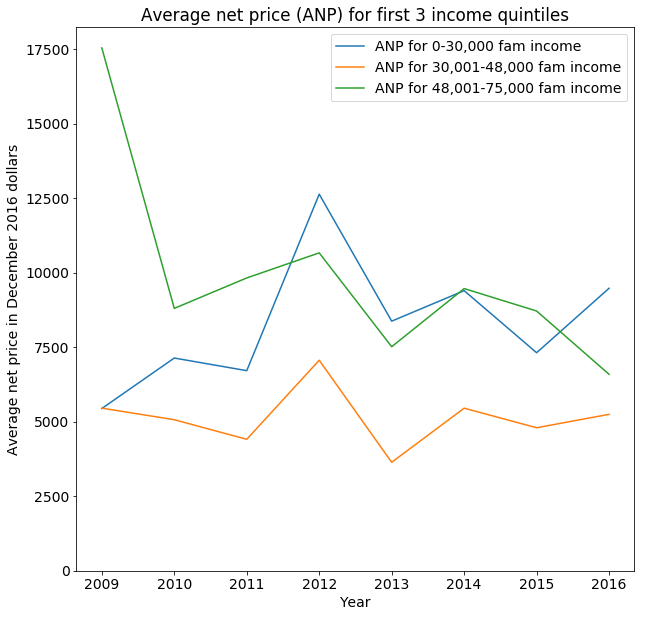

In [57]:
comparePriceLines(
    'NPT41_PRIV',
    'NPT42_PRIV',
    'NPT43_PRIV',
    title='Average net price (ANP) for first 3 income quintiles'
)

In [64]:
# Retrieves percent increase column data since 2009 for every year
def getPriceIncreases(col):
    data = getAdjustedValues(col)
    initial = data[0]
    return [
        (d - initial) / initial
        for d in data
    ]

def compareAggregatePriceIncreases(*cols, title=None):
    plt.figure(figsize=(10,10))
    for col in cols:
        plt.plot(YEARS, getPriceIncreases(col), label=colNames.get(col, col))
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Percent increase since 2009 (not adjusted for inflation)')
    plt.axhline(y=0, linestyle='--', color='#aaaaaa')
    plt.ylim(top=2,bottom=-1)
    if title:
        plt.title(title)    

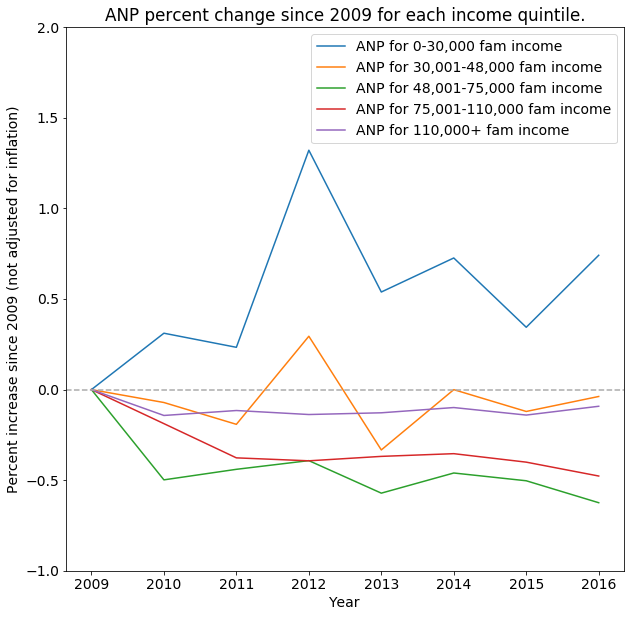

In [65]:
compareAggregatePriceIncreases('NPT41_PRIV', 'NPT42_PRIV','NPT43_PRIV','NPT44_PRIV', 'NPT45_PRIV', title="ANP percent change since 2009 for each income quintile.")

# Debt

According to the [College Scorecard Data Documentation (page 18)](https://collegescorecard.ed.gov/assets/FullDataDocumentation.pdf), debt data for each cohort (e.g. low income, medium income, pell grant students) is produced for each fiscal year. Fiscal years end on September 30, so the CPI's I use for each year are from September.

In [66]:
colNames = {
    'LO_INC_DEBT_MDN': 'median debt for 0-30k students',
    'MD_INC_DEBT_MDN': 'median debt for 30k-75k students',
    'HI_INC_DEBT_MDN': 'median debt for 75k+ students',
}

def getDebtData(col):
    adjust = inflationAdjuster('Sep')
    return [
        adjust(float(nominalRows[year - 2009][col]), year) for year in YEARS
    ]

def compareDebtLines(*cols, title=None):
    plt.figure(figsize=(10,10))
    for col in cols:
        plt.plot(YEARS, getDebtData(col), label=colNames.get(col, col))        
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Median debt (in nominal dollars)')
    plt.ylim(bottom=0)
    if title:
        plt.title(title)

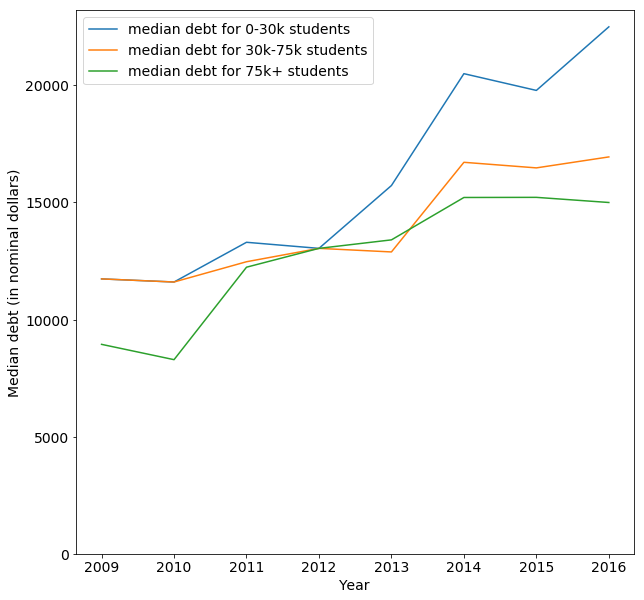

In [67]:
compareDebtLines('LO_INC_DEBT_MDN', 'MD_INC_DEBT_MDN', 'HI_INC_DEBT_MDN')

# Repyament Rates

In [70]:
colNames = {
    'CDR2_DENOM': 'number of students in two-year cohort for default',
    'CDR3_DENOM': 'number of students in three-year cohort for default',
}

def getRepaymentData(col):
    return [float(row[col]) for row in nominalRows]

def compareRepaymentLines(*cols, title=None, index=0):
    plt.subplot(2, 2, index)
    for col in cols:
        plt.plot(YEARS, getRepaymentData(col), label=colNames.get(col, col))        
    plt.legend()
    plt.ylim(top=1,bottom=0)
    if title:
        plt.title(title)

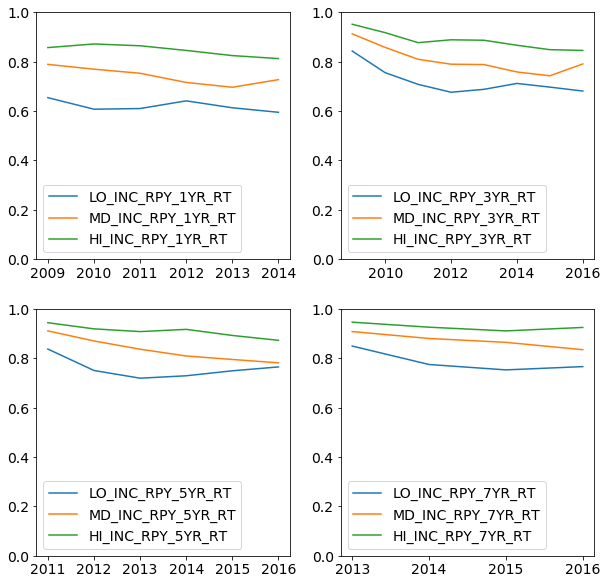

In [71]:
def compareRepayment():
    plt.figure(figsize=(10,10))
    plt.xlabel('Year')
    plt.ylabel('Repayment rate')
    for n in range(4):
        i = 2*n + 1
        compareRepaymentLines(f'LO_INC_RPY_{i}YR_RT', f'MD_INC_RPY_{i}YR_RT', f'HI_INC_RPY_{i}YR_RT', index=n+1)
        
compareRepayment()